In [36]:
#%%
# Section of the Python code where we import all dependencies on third party Python modules/libaries or our own
# libraries (exposed C++ code to Python, i.e. darts.engines && darts.physics)
from model import ModelDA
import numpy as np
import meshio
from darts.engines import *

import concurrent.futures
import math
import os
import re
import shutil
import time

import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats

In [2]:
#%%
#First we define the model that will be used as refference frac_aper = = 1e-3 (base case produced by Stephan)
# 
m_true = ModelDA(frac_aper =0.001)

# After constructing the model, the simulator needs to be initialized. The init() class method is called, which is
# inherited (https://www.python-course.eu/python3_inheritance.php) from the parent class DartsModel (found in
# darts/models/darts_model.py (NOTE: This is not the same as the__init__(self, **) method which each class (should)
# have).
m_true.init()
# Specify some other time-related properties (NOTE: all time parameters are in [days])
m_true.params.max_ts = 20  # Adjust the maximum time-step as desired (this is overwriting the max_ts specified in model.py)
m_true.run()

darts-package built on 27/03/2022 15:20:27 by SRV950$@SRV950 from d89b1a8



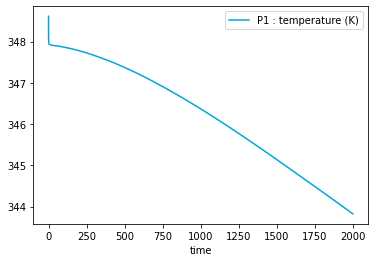

In [3]:
import pandas as pd
time_data = pd.DataFrame.from_dict(m_true.physics.engine.time_data)
writer = pd.ExcelWriter('m_true_time_data.xlsx')
time_data.to_excel(writer, 'Sheet1')
writer.save()

from darts.tools.plot_darts import *
w = m_true.reservoir.wells[1]
ax2 = plot_temp_darts(w.name, time_data)


plt.show()

In [4]:
##Create hard data from true model
obsData= np.array(time_data['P1 : temperature (K)'])
obsValues = np.array(obsData)
dObs = obsValues.T.flatten()
dTime= np.array(time_data['time']).ravel(order='F')

CeDiag =np.array(0.001*dObs[:]) #diagonal of the covariance matrix of observed data %1 of the temperature
NTimesteps=len(dTime)
NWells=1
wells = ['P1']
wellDObs = np.repeat(wells, NTimesteps) #Configure the wells list


In [6]:
#create a function to run ensemble simulations based on the prior ensemble
def RunModels(destDir, MScalar):
    for i, mMScalar in enumerate(MScalar):
        # create a model object
        m = ModelDA(frac_aper = mMScalar);
        # initialize the model
        m.init();
        # run the model
        start = time.time()
        m.run();
        # get the data
        time_data = pd.DataFrame.from_dict(m.physics.engine.time_data)
         # write timedata to output file
        time_data.to_pickle(f'{destDir}\\data_model'+str(i)+'.pkl')  
        end = time.time()
        print(f'Elapsed time: {end - start} for model {str(i)}')

In [7]:
#Read the result from the model
def ReadModels(destDir, columnsNameList, Nd, Ne):
    D = np.empty([Nd, Ne])
    for i in range(Ne):
        dataSet = pd.read_pickle(f'{destDir}\\data_model'+str(i)+'.pkl') 
        model_value=np.array([])
        for name in columnsNameList:
            model_value = np.append(model_value,dataSet[name][:])
        
        d_models = model_value.T.flatten()    
           
        D[:,i] = d_models 

    return D

In [14]:
#functions to run ES-MDA
# Finds the truncation number - if using SVD
def FindTruncationNumber(Sigma, csi):
    temp = 0
    i = 0
    svSum = np.sum(Sigma)
    stopValue = svSum * csi
    for sv in np.nditer(Sigma):
        if (temp >= stopValue):
            break
        temp += sv
        i += 1
    return i

#Series of matriz treatments to make the process less memory consuming  - 
# see  Evensen, G., The Ensemble Kalman Filter: Theoretical Formulation and Practical Implementation, Ocean Dynamics (2003)
def CentralizeMatrix(M):
    meanMatrix = np.mean(M, axis=0)
    return M - meanMatrix


def UpdateModelLocalized(M, Psi, R, DobsD):
    DeltaM = CentralizeMatrix(M)

    K = DeltaM @ Psi
    Kloc = R * K ## Kalman gain with localization 
    return M + Kloc @ DobsD 

def UpdateModel(M, Psi, DobsD):
    DeltaM = CentralizeMatrix(M)

    X10 = Psi @ DobsD
    return M + DeltaM @ X10

In [8]:
#%%
#Calculate objetive function
def calcDataMismatchObjectiveFunction(dObs, D, CeInv):
    Ne = D.shape[1]
    Nd = D.shape[0]

    Od = np.empty(Ne)
    for i in range(Ne):
        dObsD = dObs - D[:,i].reshape(Nd,1)
        Od[i] = (dObsD.T) @ (CeInv[:,np.newaxis] * dObsD)/2
    return Od

# Replaces the pattern with the value in array cosrresponding its position.
# Only 1 group per line for now...
def ReplacePattern(matchobj, array):
    return f'{array[int(matchobj.group(1))]:.2f}'

In [15]:
#Building the prior ensemble based only on frac_aper 
# problem dimensions
#Ni = m_true.nx
#Nj = m_true.ny
NGrid = 0 # Ni * Nj
NScalar = 1 #we just considering one scalar as the parameter in the problem
Nm = NGrid + NScalar
Nd = len(dTime)* 1 #  timesteps * 1 well data
Ne = 20
NTimesteps = len(dTime)
NWells = 1 #we just considering one well

# svd truncation parameter for SVD 
csi = 0.99

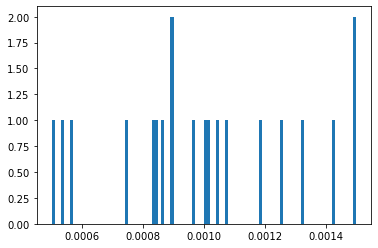

'c:\\Users\\bgy3\\OneDrive - PETROBRAS\\Documents\\PhD\\08.Simple-Fracture-Model-DARTS\\DA-DARTS-Naturally-Fractured-Reservoir-1'

In [12]:
#%%
#Generate the prior ensemble of scalar parameters
# build random values for fraction of aperture using normal distribution and fract_aper of the true model as mean as mean and 10% as std with seed=1
Em_frac_aper = np.clip(np.random.normal(1e-3, 0.5*(1e-3), Ne),0.0005,0.0015) #cliping to keep only positive numbvers for the frac apertures 

# data colums
columnsNameList = ['P1 : temperature (K)']

MScalarPrior = Em_frac_aper
#print MScalarPrioir histogram
plt.hist(MScalarPrior, bins=100)
plt.show()
#%%
curDir = os.getcwd()
srcDir =  f'{curDir}'
srcDir

In [16]:
# %%
#Run ES-MDA
SDiag = np.sqrt(CeDiag)
SInvDiag = np.power(SDiag, -1)

INd = np.eye(Nd)

MGrid = [] #not considering grid parameters
MScalar = MScalarPrior

alphas = [4., 4., 4., 4.]
l = 0
for alpha in alphas:
    # 2. Forecast

    # Generates the perturbed observations 
    z = np.random.normal(size=(Nd,Ne))
    DPObs = dObs[:,np.newaxis] + math.sqrt(alpha) * CeDiag[:,np.newaxis] * z

    # Run the simulations g(M) 
    destDir = f'{curDir}\\simulations\\it{l}'
    RunModels(destDir, MScalar)
    D = ReadModels(destDir, columnsNameList, Nd, Ne)
    if (l == 0):
        DPrior = D

    DobsD = DPObs - D

    # 4. Analysis
    # 4.1 Invert matrix C

    # Calculates DeltaD (12.5)
    meanMatrix = np.mean(D, axis=1)
    DeltaD = D - meanMatrix[:,np.newaxis]

    # Calculates CHat (12.10)
    CHat = SInvDiag[:,np.newaxis] * ( DeltaD @ DeltaD.T ) * SInvDiag[np.newaxis,:] + alpha * (Ne - 1) * INd

    # Calculates Gamma and X (12.18)
    U, SigmaDiag, Vt = np.linalg.svd(CHat)
    Nr = FindTruncationNumber(SigmaDiag, csi)

    GammaDiag = np.power(SigmaDiag[0:Nr], -1)
    X = SInvDiag[:,np.newaxis] * U[:,0:Nr]

    # Calculates M^a (12.21)
    X1 = GammaDiag[:,np.newaxis] * X.T
    X8 = DeltaD.T @ X
    X9 = X8 @ X1
    
    # subpart: for grid, use localization
    #MGrid = UpdateModelLocalized(MGrid, X9, Rmd, DobsD)

    # subpart: for scalars, don't use localization
    MScalar = UpdateModel(MScalar, X9, DobsD)
    MScalar[:] = np.clip(MScalar[:], 0.0, 1)
   
    l += 1
#%%
#MGridPost = MGrid
MScalarPost = MScalar
DPost = D



darts-package built on 27/03/2022 15:20:27 by SRV950$@SRV950 from d89b1a8

Elapsed time: 7.548060417175293 for model 0
darts-package built on 27/03/2022 15:20:27 by SRV950$@SRV950 from d89b1a8

Elapsed time: 6.003937244415283 for model 1
darts-package built on 27/03/2022 15:20:27 by SRV950$@SRV950 from d89b1a8

Elapsed time: 7.647716522216797 for model 2
darts-package built on 27/03/2022 15:20:27 by SRV950$@SRV950 from d89b1a8

Elapsed time: 8.84562373161316 for model 3
darts-package built on 27/03/2022 15:20:27 by SRV950$@SRV950 from d89b1a8

Elapsed time: 7.269292593002319 for model 4
darts-package built on 27/03/2022 15:20:27 by SRV950$@SRV950 from d89b1a8

Elapsed time: 8.659370183944702 for model 5
darts-package built on 27/03/2022 15:20:27 by SRV950$@SRV950 from d89b1a8

Elapsed time: 7.151311159133911 for model 6
darts-package built on 27/03/2022 15:20:27 by SRV950$@SRV950 from d89b1a8

Elapsed time: 5.754242420196533 for model 7
darts-package built on 27/03/2022 15:20:27 by SRV

Mean: prior=3.889e+03, post=7.984e-01
Std: prior=6.865e+03, post=2.114e+00


Text(0.5, 1.0, 'Histograms Objetive Functions')

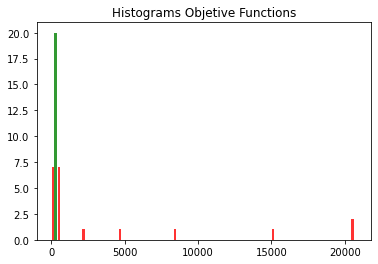

In [20]:
#%%
# Comparison of data mismatch objective function
# prior (l = 0)
CeInv = np.power(CeDiag, -1)
OPrior = calcDataMismatchObjectiveFunction(dObs[:,np.newaxis], DPrior, CeInv)
OPost = calcDataMismatchObjectiveFunction(dObs[:,np.newaxis], DPost, CeInv)

print(f'Mean: prior={np.mean(OPrior):.3e}, post={np.mean(OPost):.3e}')
print(f'Std: prior={np.std(OPrior, ddof=1):.3e}, post={np.std(OPost, ddof=1):.3e}')

fig, ax = plt.subplots()#plt.subplots(figsize=(Ne,Ne))
colors=['red','green']
x = np.stack((OPrior, OPost), axis=1)
#ax.hist(x, bins=40, alpha=0.8, color=colors, range=(x.min(),1e7))
ax.hist(x, bins=50, alpha=0.8, color=colors)
ax.set_title('Histograms Objetive Functions')

Mean: prior=9.990e-04, post=9.998e-04
Std: prior=3.003e-04, post=3.498e-06


Text(0.5, 1.0, 'Histograms Fracture Apertures before and after history matching')

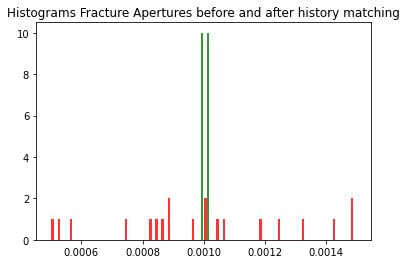

In [35]:
#Compare  the histograms of frac_aper prior and post

print(f'Mean: prior={np.mean(MScalarPrior):.3e}, post={np.mean(MScalarPost):.3e}')
print(f'Std: prior={np.std(MScalarPrior, ddof=1):.3e}, post={np.std(MScalarPost, ddof=1):.3e}')


fig, ax = plt.subplots()#plt.subplots(figsize=(Ne,Ne))
colors=['red','green']
x = np.stack((MScalarPrior, MScalarPost), axis=1)
#ax.hist(x, bins=40, alpha=0.8, color=colors, range=(x.min(),1e7))
ax.hist(x, bins=50, alpha=0.8, color=colors)
ax.set_title('Histograms Fracture Apertures before and after history matching')



Text(0.5, 0.98, 'P1 : temperature (K)')

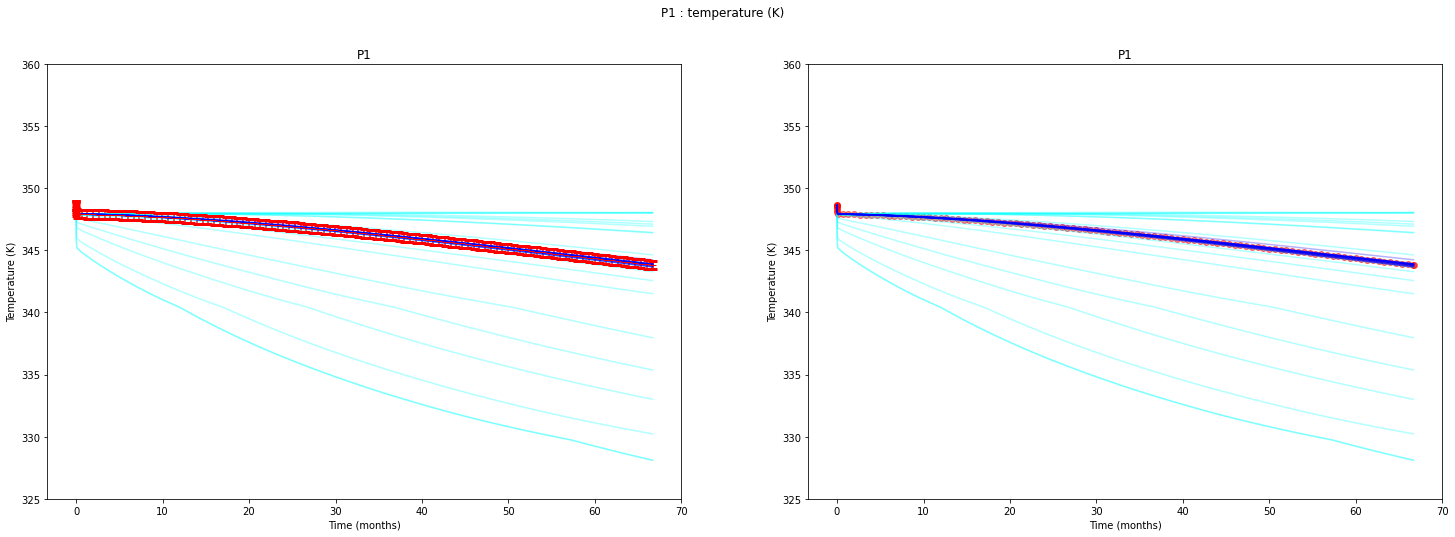

In [33]:
#%%
# Plots of oil and water rate at wells
# Split the data into data array
wellDataPriorArray = np.split(DPrior, NWells)
wellDataPostArray = np.split(DPost, NWells)
wellDataObsArray = np.split(dObs, NWells)
wellDataObsErrorArray = np.split(CeDiag, NWells)

wellSubtitle = ['P1']
timeMonths = dTime/30.0

# Plot oil data
# get data and store in an array
prior = wellDataPriorArray # wellDataPriorArray[0:11:2]
post = wellDataPostArray # wellDataPostArray[0:11:2]
plotObsData = wellDataObsArray #wellDataObsArray[0:11:2]
errObsData = wellDataObsErrorArray #wellDataObsErrorArray[0:11:2]

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(25,8))
axFlat = ax.flatten()

axFlat[0].set_facecolor('white')
axFlat[0].plot(timeMonths, prior[i], color='#00FFFF', alpha=0.3)
axFlat[0].plot(timeMonths, post[i], color='b', alpha=0.3)
axFlat[0].errorbar(timeMonths, plotObsData[i], yerr=errObsData[i], fmt='_ r', capthick=3, capsize=4)
#axFlat[0].plot(timeMonths, plotObsData[i],color='red', alpha=0.5)
axFlat[0].set_title(wellSubtitle[0])
axFlat[0].set_xlabel('Time (months)')
axFlat[0].set_ylabel('Temperature (K)')
axFlat[0].set_ylim([325, 360])


axFlat[1].plot(timeMonths, prior[i], color='#00FFFF', alpha=0.3)
axFlat[1].plot(timeMonths, post[i], color='b', alpha=0.3)
axFlat[1].scatter(timeMonths, plotObsData[0],color='red', alpha=0.5)
axFlat[1].set_title(wellSubtitle[0])
axFlat[1].set_xlabel('Time (months)')
axFlat[1].set_ylabel('Temperature (K)')
axFlat[1].set_ylim([325, 360])
fig.suptitle('P1 : temperature (K)')
